In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Consistent color scheme across ALL figures
color_map = {
    "Recovery Achieved": "#2ca02c",   # green
    "Not Achieved": "#ff7f0e",         # orange
    "Delay Worsened": "#d62728"        # red
}


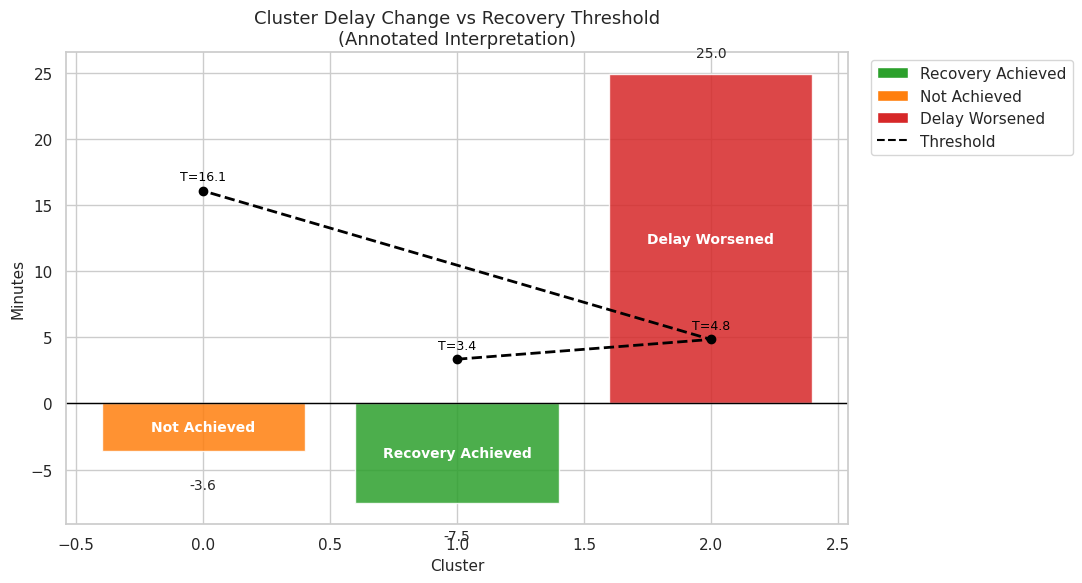

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("exports/cluster_summary.csv")

bar_colors = df["recovery_status"].map(color_map)

plt.figure(figsize=(11,6))

# Bar plot: Mean Delay Change
bars = plt.bar(
    df["cluster"],
    df["DELAY_CHANGE"],
    color=bar_colors,
    alpha=0.85,
    label="Mean Delay Change"
)

# Threshold line
plt.plot(
    df["cluster"],
    df["threshold"],
    marker="o",
    linestyle="--",
    color="black",
    linewidth=2,
    label="Recovery Threshold"
)

# Zero reference line
plt.axhline(0, color="black", linewidth=1)

# Annotate bars
for bar, dc in zip(bars, df["DELAY_CHANGE"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        dc + (1 if dc >= 0 else -2),
        f"{dc:.1f}",
        ha="center",
        va="bottom" if dc >= 0 else "top",
        fontsize=10
    )

# Annotate thresholds
for x, t in zip(df["cluster"], df["threshold"]):
    plt.text(
        x,
        t + 0.8,
        f"T={t:.1f}",
        ha="center",
        fontsize=9,
        color="black"
    )

# Annotate recovery status labels
for _, row in df.iterrows():
    plt.text(
        row["cluster"],
        row["DELAY_CHANGE"] / 2,
        row["recovery_status"],
        ha="center",
        va="center",
        fontsize=10,
        color="white",
        fontweight="bold"
    )

# Axis labels and title
plt.xlabel("Cluster", fontsize=11)
plt.ylabel("Minutes", fontsize=11)
plt.title("Cluster Delay Change vs Recovery Threshold\n(Annotated Interpretation)", fontsize=13)

# Custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=color_map["Recovery Achieved"], label="Recovery Achieved"),
    Patch(facecolor=color_map["Not Achieved"], label="Not Achieved"),
    Patch(facecolor=color_map["Delay Worsened"], label="Delay Worsened"),
]

plt.legend(
    handles=legend_elements + [plt.Line2D([0], [0], color="black", linestyle="--", label="Threshold")],
     bbox_to_anchor=(1.02, 1),
    loc="upper left"
)


plt.tight_layout()
plt.show()

# 3 clusters
#160 minutes dep_delay =  meaningful threshold I kept 10% of the delay time atleast so, 16 min, but recovered only by 3.6 min therefore not achieved
#33.5 min dep_delay  =  threshold 3.35 min. but recovered by 7.5 min therefore achieved
#48.5 min dep_delay = threshold is 4.85 min but was late by 25 min and not recovered at all therefore worsened


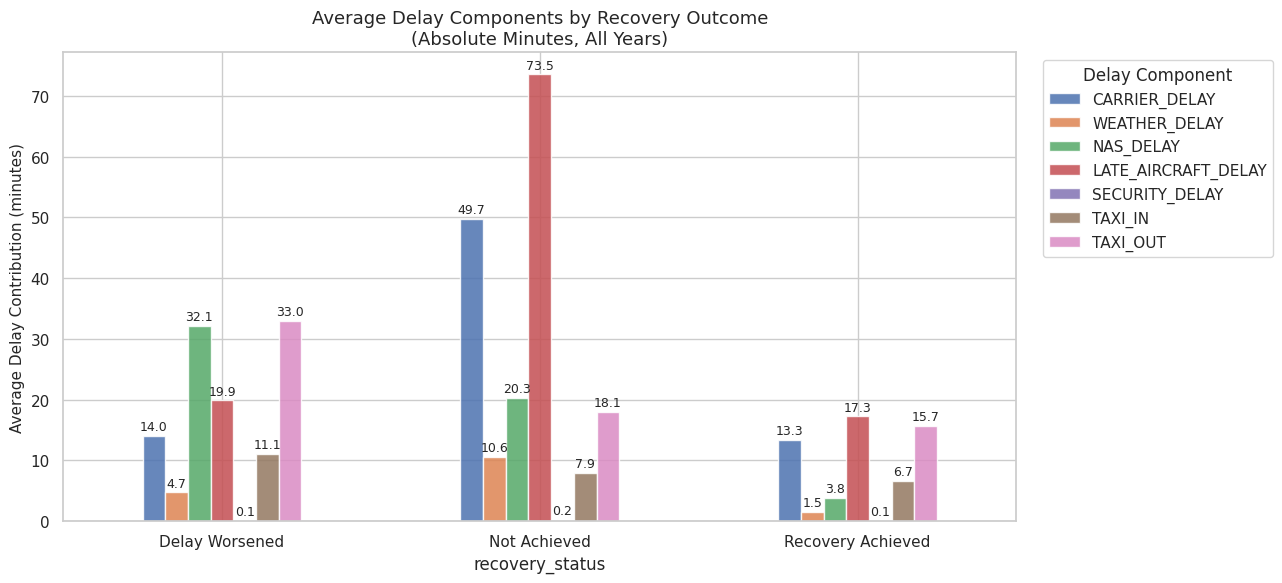

In [16]:
df_abs = pd.read_csv("exports/agg_all_absolute.csv")
df_abs = df_abs.set_index("recovery_status")

fig, ax = plt.subplots(figsize=(13,6))

df_abs.plot(
    kind="bar",
    ax=ax,
    alpha=0.85
)

# Annotate bars with values
for container in ax.containers:
    ax.bar_label(
        container,
        fmt="%.1f",
        fontsize=9,
        padding=2
    )

ax.set_ylabel("Average Delay Contribution (minutes)", fontsize=11)
ax.set_title(
    "Average Delay Components by Recovery Outcome\n(Absolute Minutes, All Years)",
    fontsize=13
)

ax.set_xticklabels(df_abs.index, rotation=0)

# Legend cleanup
ax.legend(
    title="Delay Component",
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()


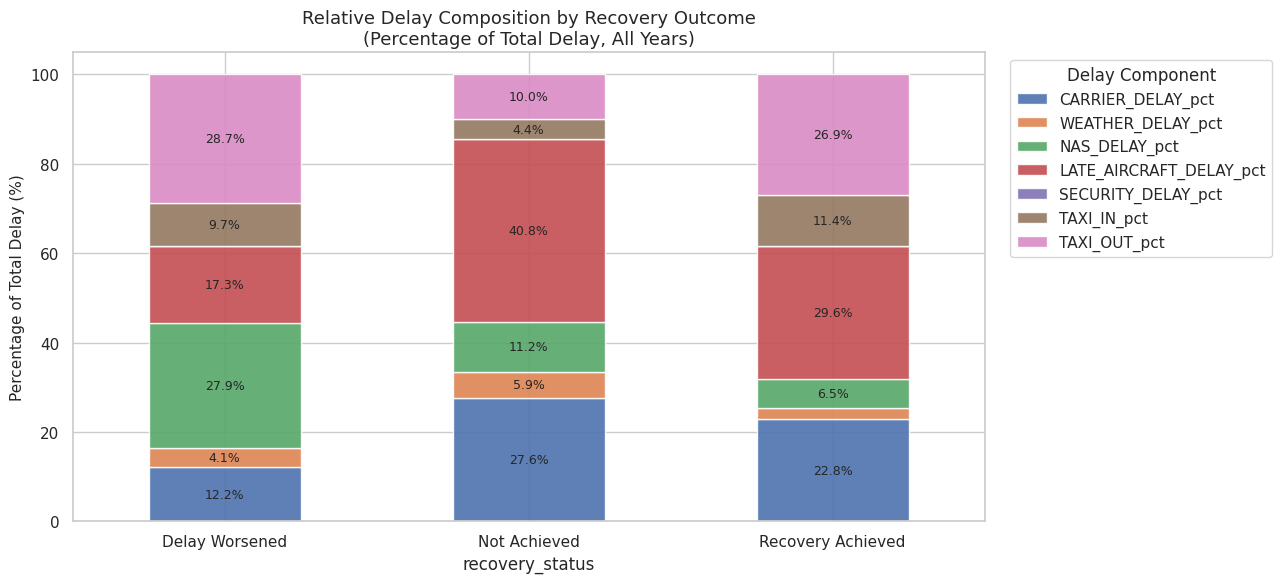

In [18]:
df_pct = pd.read_csv("exports/agg_all_percent.csv")
df_pct = df_pct.set_index("recovery_status")

fig, ax = plt.subplots(figsize=(13,6))

df_pct.plot(
    kind="bar",
    stacked=True,
    ax=ax,
    alpha=0.9
)

# Annotate percentage labels inside stacks
for container in ax.containers:
    labels = [
        f"{v:.1f}%" if v > 4 else ""  # hide tiny slices
        for v in container.datavalues
    ]
    ax.bar_label(
        container,
        labels=labels,
        label_type="center",
        fontsize=9
    )

ax.set_ylabel("Percentage of Total Delay (%)", fontsize=11)
ax.set_title(
    "Relative Delay Composition by Recovery Outcome\n(Percentage of Total Delay, All Years)",
    fontsize=13
)

ax.set_xticklabels(df_pct.index, rotation=0)

ax.legend(
    title="Delay Component",
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()


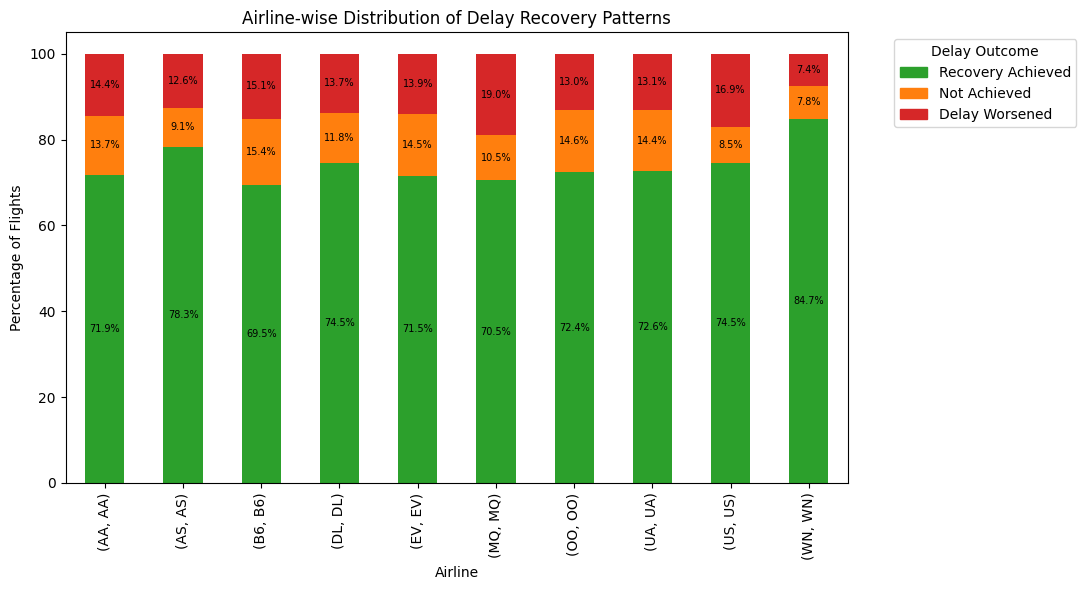

In [14]:
df = pd.read_csv("exports/flight_delay_clusters_labeled.csv")


# Top 10 airlines by number of flights
top_airlines = (
    df["OP_UNIQUE_CARRIER"]
    .value_counts()
    .head(10)
    .index
)

df_top = df[df["OP_UNIQUE_CARRIER"].isin(top_airlines)]

# Airline-wise percentage distribution of recovery status
airline_recovery_pct = (
    df_top
    .groupby(["OP_UNIQUE_CARRIER", "recovery_status"])
    .size()
    .groupby(level=0)
    .apply(lambda x: 100 * x / x.sum())
    .unstack()
    .fillna(0)
)

status_order = ["Recovery Achieved", "Not Achieved", "Delay Worsened"]
airline_recovery_pct = airline_recovery_pct[status_order]


ax = airline_recovery_pct.plot(
    kind="bar",
    stacked=True,
    figsize=(11, 6),
    color=[color_map[s] for s in status_order]
)


for i, airline in enumerate(airline_recovery_pct.index):
    cumulative = 0
    for status in status_order:
        value = airline_recovery_pct.loc[airline, status]
        if value >= 5:  
            ax.text(
                i,
                cumulative + value / 2,
                f"{value:.1f}%",
                ha="center",
                va="center",
                fontsize=7,
                color="black"
            )
        cumulative += value


plt.xlabel("Airline")
plt.ylabel("Percentage of Flights")
plt.title("Airline-wise Distribution of Delay Recovery Patterns")


legend_patches = [Patch(color=color_map[s], label=s) for s in status_order]
plt.legend(
    handles=legend_patches,
    title="Delay Outcome",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()


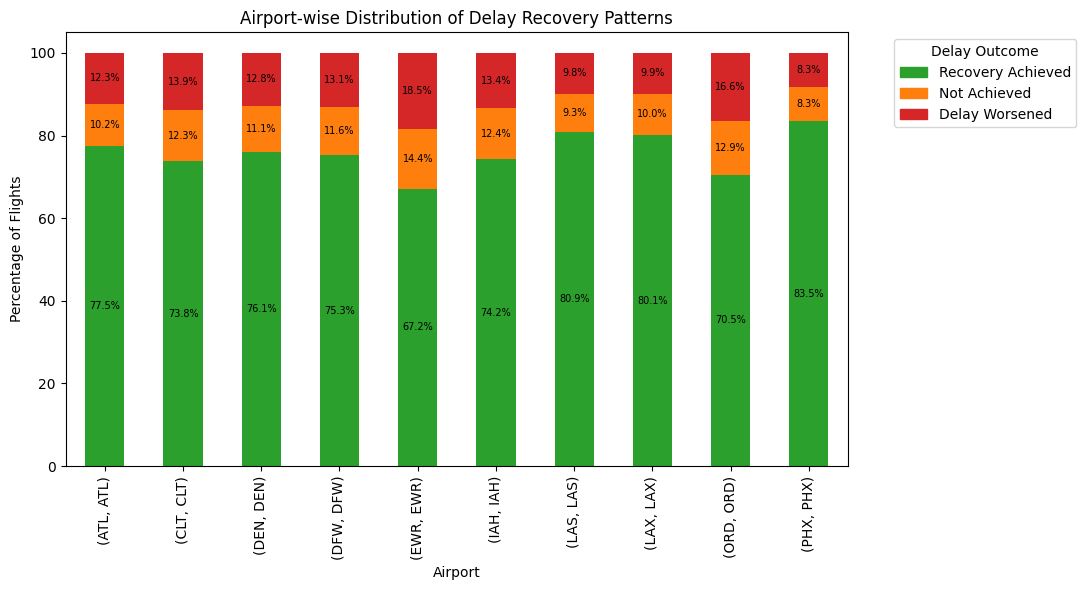

In [11]:
df = pd.read_csv("exports/flight_delay_clusters_labeled.csv")

# Top 10 airports
top_airports = df["ORIGIN"].value_counts().head(10).index
df_top = df[df["ORIGIN"].isin(top_airports)]

# Airport-wise recovery percentage
airport_recovery_pct = (
    df_top
    .groupby(["ORIGIN", "recovery_status"])
    .size()
    .groupby(level=0)
    .apply(lambda x: 100 * x / x.sum())
    .unstack()
    .fillna(0)
)

ordered_labels = ["Recovery Achieved", "Not Achieved", "Delay Worsened"]
airport_recovery_pct = airport_recovery_pct[ordered_labels]


ax = airport_recovery_pct.plot(
    kind="bar",
    stacked=True,
    figsize=(11, 6),
    color=[color_map[o] for o in ordered_labels]
)


for i, airport in enumerate(airport_recovery_pct.index):
    cumulative = 0
    for status in ordered_labels:
        value = airport_recovery_pct.loc[airport, status]
        if value >= 5:  
            ax.text(
                i,
                cumulative + value / 2,
                f"{value:.1f}%",
                ha="center",
                va="center",
                fontsize=7,
                color="Black"
            )
        cumulative += value


plt.xlabel("Airport")
plt.ylabel("Percentage of Flights")
plt.title("Airport-wise Distribution of Delay Recovery Patterns")

legend_patches = [Patch(color=color_map[o], label=o) for o in ordered_labels]
plt.legend(
    handles=legend_patches,
    title="Delay Outcome",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()
